In [ ]:
# Useful imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import torchvision.models
import matplotlib.pyplot as plt
import time

In [ ]:
# Pytorch seed for reproducable results
torch.manual_seed(1000)
torch.use_deterministic_algorithms(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Retrieve images
!unzip /content/drive/MyDrive/APS360_Project/Mushaugm2.zip -d /content/Mushaugm2
!unzip /content/drive/MyDrive/APS360_Project/Mush_val.zip -d /content/Mush_val
!unzip /content/drive/MyDrive/APS360_Project/Mush_test.zip -d /content/Mush_test

Archive:  /content/drive/MyDrive/APS360_Project/Mushaugm2.zip
replace /content/Mushaugm2/Entoloma/image_1002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/APS360_Project/Mush_val.zip
replace /content/Mush_val/Agaricus/image_1010.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/APS360_Project/Mush_test.zip
replace /content/Mush_test/Agaricus/image_111.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Get dataloader for the train, validation, and test set
def get_data_loader(batch_size):
    # Normalize images to the range [-1, 1]
    transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load Datasets
    train_data = torchvision.datasets.ImageFolder('/content/Mushaugm2', transform=transform)
    val_data = torchvision.datasets.ImageFolder('/content/Mush_val', transform=transform)
    test_data = torchvision.datasets.ImageFolder('/content/Mush_test', transform=transform)
    
    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader, test_loader

In [ ]:
# Verify that the dataloader works
train_loader, val_loader, test_loader = get_data_loader(batch_size = 1)

print("Num training images:", len(train_loader))
print("Num validation images:", len(val_loader))
print("Num test images:", len(test_loader))

Num training images: 18000
Num validation images: 1335
Num test images: 669


In [ ]:
# Download a pretrained vgg net model
vgg_full_model = torchvision.models.vgg19(pretrained=True, progress=False)
VGGCL = vgg_full_model.features

In [ ]:
# check the dimension of the output of vgg
test, labels = next(iter(train_loader))
print(test.shape)
test = VGGCL(test)
print(test.shape)

torch.Size([1, 3, 240, 240])
torch.Size([1, 512, 7, 7])


In [ ]:
# Fully connected model
class ClassyMush(nn.Module):
    def __init__(self):
        super(ClassyMush, self).__init__()
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 9)

    def forward(self, x):
        x = x.view(-1, 512 * 7 * 7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [ ]:
# Define training and accuracy functions
def get_accuracy(model, loader):
  correct = 0
  total = 0
  for imgs, labels in loader:
    
    # Move images and labels to the gpu
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    with torch.no_grad():
      output = model(VGGCL(imgs))
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]

    # Remove bytes from the cuda storage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cpu()
      labels = labels.cpu()
  return correct / total

# Calculate the accuracy quickly during training
def quick_acc_loss(model, criterion, loader):
  imgs, labels = next(iter(loader))
  
  # Move images and labels to the gpu
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()

  with torch.no_grad():
    output = model(VGGCL(imgs))
  
  # calculate loss
  loss = criterion(output, labels)

  # select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct = pred.eq(labels.view_as(pred)).sum().item()
  total = imgs.shape[0]

  # Remove bytes from the cuda storage
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cpu()
    labels = labels.cpu()
  
  # Only take the first batch for an accuracy approximation
  return correct / total, float(loss) / total

def get_model_name(batch_size, learning_rate, epoch):
  path = "/content/drive/MyDrive/APS360_Project/VGGstates/bs{}_lr{}_e{}.pt".format(batch_size, learning_rate, epoch)
  return path

def train_net(net, batch_size, learning_rate=0.01, num_epochs=30, save_rate=5):
  # Cross Entropy loss criterion
  criterion = nn.CrossEntropyLoss()

  # Stochastic Gradient Descent
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
  
  # Use lists to track accuracy and loss
  iters, train_loss, train_acc, val_loss, val_acc = [], [], [], [], []

  # training
  start_time = time.time()
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
    for images, labels in iter(train_loader):
      
      # Move images and labels to the gpu
      if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      
      with torch.no_grad():
        mid = VGGCL(images)

      out = net(mid)                      # forward pass
      loss = criterion(out, labels)       # compute the total loss
      loss.backward()                     # backward pass (compute parameter updates)
      optimizer.step()                    # make the updates for each parameter
      optimizer.zero_grad()               # a clean up step for PyTorch

      ### save the current training information ###
      
      # Iteration index
      iters.append(n)

      # average loss
      train_loss.append(float(loss)/batch_size)

      # compute quick validation accuracy
      v_a, v_l = quick_acc_loss(net, criterion, val_loader)
      val_acc.append(v_a)
      val_loss.append(v_l)
      
      # compute quick training accuracy 
      pred = out.max(1, keepdim=True)[1]
      correct = pred.eq(labels.view_as(pred)).sum().item()
      total = images.shape[0]
      train_acc.append(correct / total)
      
      # Remove bytes from the cuda storage
      if use_cuda and torch.cuda.is_available():
        images = images.cpu()
        labels = labels.cpu()

      n += 1
    print(("Iteration {}: Train acc: {:.6f} loss: {:.6f} |"+
            " Validation acc: {:.6f} loss: {:.6f}").format(n,
            train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1]))
    
    if (epoch+1) % save_rate == 0:
      # Save the current model (checkpoint) to a file
      print("Saving at epoch {}... ".format(epoch + 1), end='')
      model_path = get_model_name(batch_size, learning_rate, epoch + 1)
      torch.save(net.state_dict(), model_path)
      print("Done")

  # Caculate computation time
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # save the final model
  print("Saving the final model... ", end='')
  model_path = get_model_name(batch_size, learning_rate, epoch + 1)
  torch.save(net.state_dict(), model_path)
  print("Done")

  # Write the train/val err and loss into CSV file for plotting later
  print("Writing training statistics to file... ", end='')
  np.savetxt("training_data.csv", 
             [iters, train_loss, train_acc, val_loss, val_acc])
  print("Done")

  print('\nFinished Training, Calculating final accuracy...')
  final_train_acc = get_accuracy(net, train_loader)
  final_val_acc = get_accuracy(net, val_loader)
  print('Final accuracy: training: {:.2f} | validation: {:.2f}'.format(
      final_train_acc,
      final_val_acc
  ))


def plot_training_curve(path):
    iters, train_loss, train_acc, val_loss, val_acc = np.loadtxt(path)
    
    # plotting
    plt.figure(1, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Loss Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
use_cuda = True

batch_size = 250
learning_rate = 1e-3
num_epochs = 20
save_rate = 10

# Initialize model
model = ClassyMush()

if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model = model.cuda()
  VGGCL = VGGCL.cuda()

# Initialize loaders
train_loader, val_loader, test_loader = get_data_loader(batch_size)

# Train the model
train_net(model, batch_size, learning_rate=learning_rate, num_epochs=num_epochs, save_rate=save_rate)

Iteration 72: Train acc: 0.660000 loss: 0.004206 | Validation acc: 0.620000 loss: 0.004356
Iteration 144: Train acc: 0.756000 loss: 0.003282 | Validation acc: 0.668000 loss: 0.003911
Iteration 216: Train acc: 0.828000 loss: 0.002253 | Validation acc: 0.656000 loss: 0.003916
Iteration 288: Train acc: 0.884000 loss: 0.001621 | Validation acc: 0.732000 loss: 0.003251
Iteration 360: Train acc: 0.936000 loss: 0.001257 | Validation acc: 0.736000 loss: 0.003204
Iteration 432: Train acc: 0.936000 loss: 0.001340 | Validation acc: 0.748000 loss: 0.003280
Iteration 504: Train acc: 0.956000 loss: 0.000799 | Validation acc: 0.692000 loss: 0.003633
Iteration 576: Train acc: 0.960000 loss: 0.000926 | Validation acc: 0.708000 loss: 0.003655
Iteration 648: Train acc: 0.980000 loss: 0.000698 | Validation acc: 0.756000 loss: 0.003095
Iteration 720: Train acc: 0.996000 loss: 0.000480 | Validation acc: 0.752000 loss: 0.003290
Saving at epoch 10... Done
Iteration 792: Train acc: 0.992000 loss: 0.000450 | Va

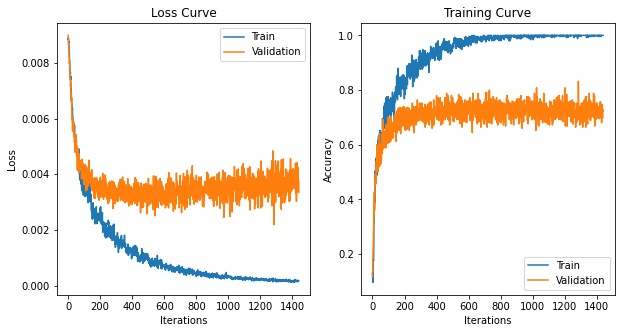

In [ ]:
# Plot the results
plot_training_curve("training_data.csv")